# Тестовое задание на стажировку (NER, IDP, NLP)  
## Чирков Богдан

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 40)

## Задание 1. Описание задачи

Задача извлечения сущностей из текстовых документов, более известная как NER (Named Entity Recognition), возникла около 30 лет назад, и с тех пор активно изучалась. Её суть сводится к поиску и классификации слов/словосочетаний/аббревиатур и прочих, представляющих из себя именованных сущностей. Самые частые категории: название людей, организаций, мест, событий и продуктов.  

Среди решений выделяются следующие наиболее популярные типы:
- rule-based методы: выделение сущностей в соответствии с правилами грамматики и орфографии (уважительные обращения, заглавные буквы, подготовленные словари и паттерны), использование регулярных выражений;
- классический ML: CRF (Conditional Random Fields), SVM (Support Vector Machine) или HMM (Hidden Markov Model), предобработка текста;
- нейросетевые методы: трансформеры (BERT), attention (LSTM-CRF), fine-tuning.  

Вместе с этим на сегодняшний день активно применяют LLM для решения задачи NER. Это объясняется несколькими особенностями языковых моделей: они лучше других моделей "понимают" контекст, особенности языка и лингвистические правила и связи между словами/символами/токенами. Более того, качество ответов может улучшиться за счёт правильно сформированных промптов.  

Задача NER похожа на классификацию: мы относим слова к той или иной категории, поэтому наиболее частыми метриками являются Precision, Recall, F1-score, F-beta score. Однако часто одну сущность могут называть словосочетаниями, не одним словом ("Джон Доу", "Европейский союз" и проч.), поэтому есть разные виды учёта точности: точные либо частичные совпадения.

## Задание 2. Создание датафрейма

    К сожалению, на момент завершения данного исследования я так и не получил ответ по поводу строения датафрейма, поэтому руководствовался своей интуицией.

In [2]:
import os

def process_train_text(data_dir: str) -> dict[str, str]:
    """
    Загружает новостные данные, убирает метаданные и создает словарь с получившимися новостями.
    
    :param data_dir: директория с текстовыми файлами новостей.
    :return: обработанные новости в виде словаря (ключ - id).
    """
    data = dict()
    
    for file_name in os.listdir(data_dir):
        with open(data_dir + '/' + file_name, "r", encoding="utf-8") as f:
            lines = f.readlines()

        id = lines[0].replace('\n', '')
        data[id] = ''.join(lines[4:])
    
    return data

def process_ans_text(ans_dir: str) -> dict[str, str]:
    """
    Загружает и форматирует правильные ответы к выделенным сущностям из новостей.
    
    :param ans_dir: директория с ответами.
    :return: обработанные ответы в виде словаря (ключ - id).
    """
    data = dict()

    for file_name in os.listdir(ans_dir):
        with open(ans_dir + '/' + file_name, "r", encoding="utf-8") as f:
            lines = f.readlines()

        res = []
        for line in lines[1:]:
            parts = line.split("\t")  
            word, _, entity_type, _ = parts
            res.append(word + '\t' + entity_type)

        id = lines[0].replace('\n', '')
        data[id] = '\n'.join(res)

    return data


In [3]:
train_text = process_train_text("train_data")
ans_text = process_ans_text("ans_data")

df = pd.DataFrame({
    'document_id': train_text.keys(),
    'document_text': train_text.values(),
#   'entity': 'PER',
    'gold_answer': ans_text.values()})

df.head()

,document_id,document_text,gold_answer
0,ru-1000,Подробности.ua: Третий за сутки: Бор...,Brexit\tEVT\nThe Guardian\tPRO\nБори...
1,ru-1013,МИД РФ: Борис Джонсон не захотел ост...,Brexit\tEVT\nFacebook\tPRO\nREGNUM\t...
2,ru-1037,Отставка министра по Брекзиту Велико...,Борис Джонсон\tPER\nБориса Джонсона\...
3,ru-1061,09.07.2018 18:30 : Курс фунта стерли...,Бориса Джонсона\tPER\nВеликобритании...
4,ru-1070,"Туск выразил сожаление, что идея Bre...",Brexit\tEVT\nБорис Джонсон\tPER\nБри...


## Задание 3. Создание промптов

В качестве стратегии по составлении промпта выбран one-shot prompting с примером из тренировочного датасета для улучшения контекста.

In [4]:
def make_prompt(row: pd.Series) -> str:
    prompt = f'''Найди именованные сущности (имена людей (PER), организации (ORG), локации (LOC), событий (EVT) и продуктов (PRO)) в тексте. Для каждой сущности выведи ответ в виде "упоминание-сущности <TAB> категория".
Пример:
Вход: "Премьер-министр Великобритании Тереза Мей приняла отставку министра иностранных дел Бориса Джонсона.
Это связано с несогласием относительно планов отношения Великобритании и ЕС после официального выхода страны из Евросоюза. Ранее по этой же причине в отставку ушел британский министр по делам «Брекзит» Дэвид Дэвис."
Выход: "Бориса Джонсона\tPER\nБрекзит\tEVT\nВеликобритании\tLOC\nДэвид Дэвис\tPER\nЕС\tORG\nЕвросоюза\tORG\nТереза Мей\tPER"

Теперь обработай этот текст:
{row['document_text']}
'''
    return prompt

In [5]:
def write_prompt(row: pd.Series) -> None:
    with open("prompts_data/prompt." + row['document_id'] + ".txt", "w", encoding="utf-8") as file:
        prompt = make_prompt(row)
        file.write(prompt)
        
# df.apply(write_prompt, axis=1)

## Задание 4. Получаем ответы GigaChat'а

Добавим колонку с ответами GigaChat'а.

In [6]:
def process_gigachat_text(gigachat_dir: str) -> dict[str, str]:
    """
    Загружает и форматирует ответы языковой модели к выделенным сущностям.
    
    :param lines: сырые строки новости
    :return: обработанная новость
    """
    data = dict()

    for file_name in os.listdir(gigachat_dir):
        with open(gigachat_dir + '/' + file_name, "r", encoding="utf-8") as f:
            lines = f.readlines()

        id = file_name.split('.')[1]
        data[id] = ''.join(lines)

    return data

# gigachat_text = process_gigachat_text("gigachat_data")
# df['gigachat_text'] = df['document_id'].map(gigachat_text)

In [7]:
gigachat = pd.read_csv("gigachat_data.csv")
df['gigachat_text'] = gigachat['gigachat_text']
df.fillna({'gigachat_text': ''}, inplace=True)

df.head(5)

,document_id,document_text,gold_answer,gigachat_text
0,ru-1000,Подробности.ua: Третий за сутки: Бор...,Brexit\tEVT\nThe Guardian\tPRO\nБори...,Борис Джонсон\tPER\nВеликобритании\t...
1,ru-1013,МИД РФ: Борис Джонсон не захотел ост...,Brexit\tEVT\nFacebook\tPRO\nREGNUM\t...,Борис Джонсон\tPER\nВеликобритания\t...
2,ru-1037,Отставка министра по Брекзиту Велико...,Борис Джонсон\tPER\nБориса Джонсона\...,Борис Джонсон\tPER\nВеликобритания\t...
3,ru-1061,09.07.2018 18:30 : Курс фунта стерли...,Бориса Джонсона\tPER\nВеликобритании...,Борис Джонсон\tPER\nВеликобритании\t...
4,ru-1070,"Туск выразил сожаление, что идея Bre...",Brexit\tEVT\nБорис Джонсон\tPER\nБри...,


In [8]:
# df[['document_id', 'gigachat_text']].to_csv("gigachat_data.csv", index=False)

## Задание 5. Имплементация метрик

Реализуем F1-score, поскольку контекст задачи не позволяет сделать четкий выбор в сторону Precision или Recall и нам бы хотелось учитывать обе метрики. Вместе с тем решено использовать облегчённый критерий совпадения ответов, а именно проверять, смогла ли модель найти правильно классифицировать сущности в предложении без поиска инфинитивной формы, как было предложено в оригинальном соревновании: у нас ещё нет представления о том, насколько хороша или плоха модель в поиске сущностей, поэтому протестируем её на минимальных требованиях.

In [9]:
from score_fn import score_fn

df['score'] = df.apply(lambda row: score_fn(row['gold_answer'], row['gigachat_text']), axis=1)

Данные вычисления можно ускорить через векторизацию: в pandas реализованы векторизованные функции для работы со строками, однако поиск пересечений между предсказаниями (по крайней мере для меня сейчас) остается чем-то нетривиальным, и кажется, что векторизовать это трудно.

## Задание 6. Подсчёт метрик

Посчитаем метрики по категориям сущностей.

In [10]:
from score_fn import score_fn_for_category

categories = ['PER', 'LOC', 'ORG', 'EVT', 'PRO']
scores_for_category = pd.DataFrame(columns=['document_id'] + categories)
scores_for_category['document_id'] = train_text.keys()

for cat in categories:
    scores = df.apply(lambda row: score_fn_for_category(row['gold_answer'], row['gigachat_text'], cat), axis=1)
    scores_for_category[cat] = scores

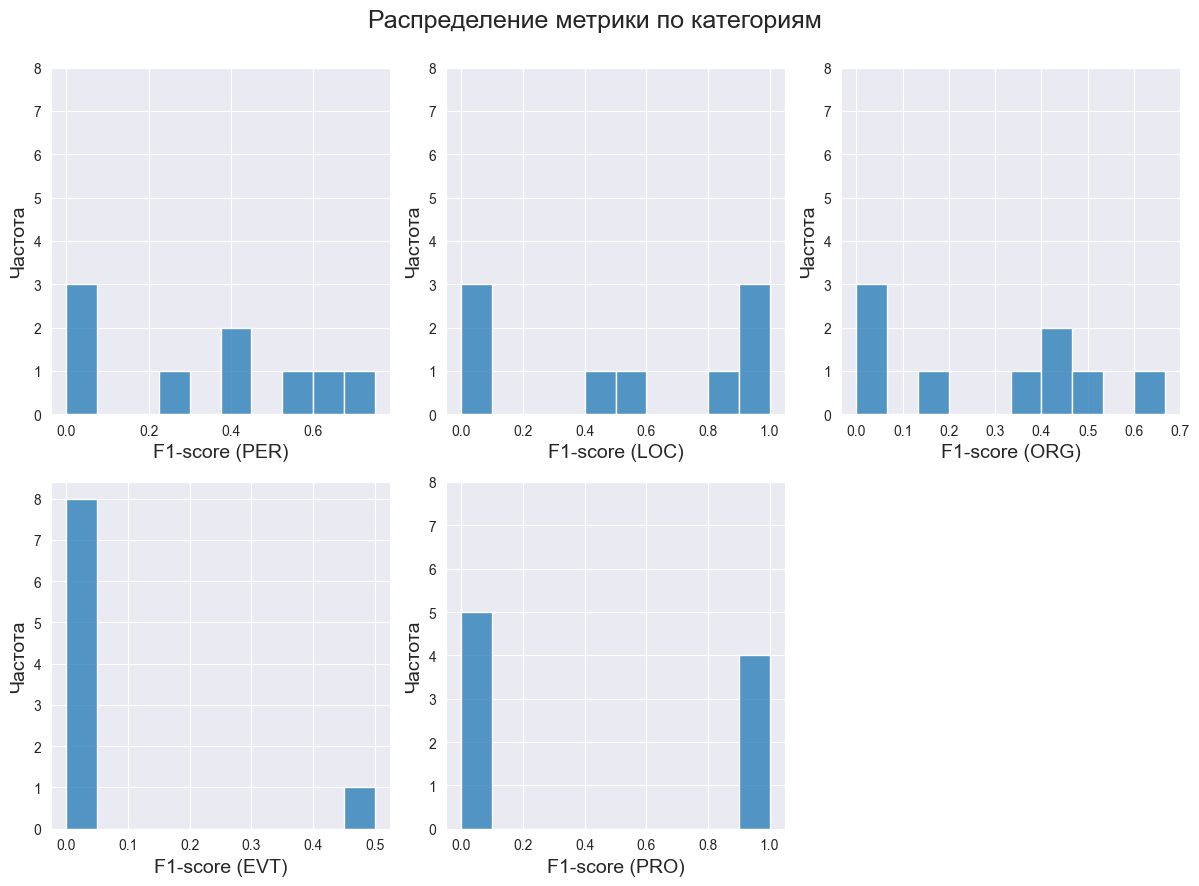

In [11]:
plt.figure(figsize=(12, 9))

for i in range(5):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=scores_for_category[categories[i]], bins=10)
    plt.xlabel(f'F1-score ({categories[i]})', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.yticks(np.arange(0, 9, 1))


plt.gcf().suptitle("Распределение метрики по категориям", fontsize=18)
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.98))
plt.show()

Как можно видеть из графиков, хуже всего GigaChat выделяет события, а лучше всего - локации и организации.

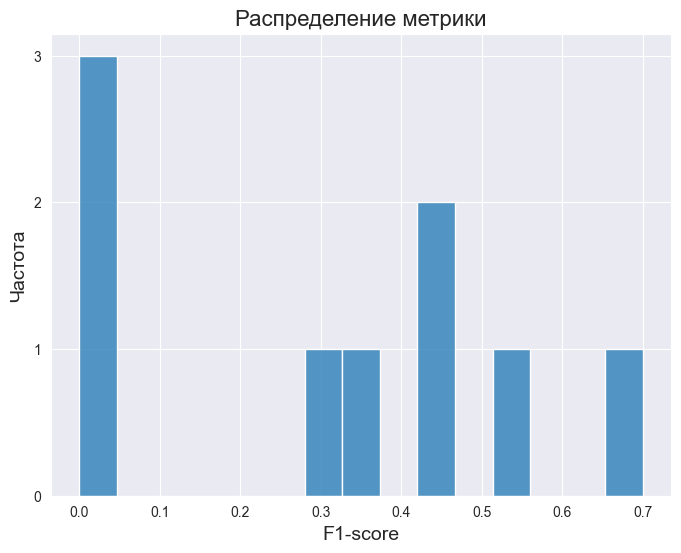

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(df['score'], bins=15)
plt.title('Распределение метрики', fontsize=16)
plt.xlabel('F1-score', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.yticks(np.arange(0, 4, 1))
plt.show()

Грустное распределение, конечно. Очень попортили картину 3 документа, на которые GigaChat отказался давать ответы. Судя по всему имеет место цензурирование, из чего можно сделать вывод, что скорее всего модель лучше восприняла последние предложения (связанные с политикой - потенциально опасной темой для генеративных моделей с точки зрения этики), а начало промпта забылось.

## Задание 7. Зависимость метрик от длины документа

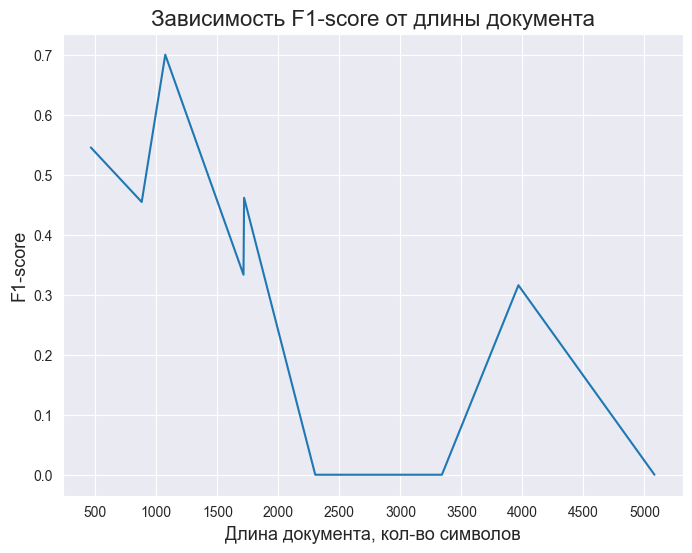

In [13]:
df['document_length'] = df['document_text'].apply(lambda x: len(x))
df.sort_values(by='document_length', ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
plt.plot(df['document_length'], df['score'])
plt.title('Зависимость F1-score от длины документа', fontsize=16)
plt.xlabel('Длина документа, кол-во символов', fontsize=13)
plt.xticks(np.arange(500, 5001, 500))
plt.ylabel('F1-score', fontsize=13)
plt.show()

Да, между длиной входных данных и метрикой есть отрицательная зависимость, что можно объяснить тем, что чем больше входной текст, тем труднее удержать весь контекст.

In [15]:
corr = np.corrcoef(df['document_length'], df['score'])[0, 1]
print(f"Корреляция между длиной и f1-score'ом = {corr:.4f}")

Корреляция между длиной и f1-score'ом = -0.7437


## Задание 8. Анализ ошибок

Можно отметить, что на точность ответов влияют:
- длина документа и, как следствие, длина промпта,
- тип обнаружаемой сущности,
- уровень элайнмента выбранной языковой модели,
- качество составленного промпта. 

Вместе с тем стоит сказать, что, возможно, дело также в создании промпта: в силу быстрой утери контекста имеет место попробовать zero-shot prompting, либо более короткий пример в отличие от выбранного мной.
Помимо этого можно использовать имеющиеся размеченные данные, чтобы дообучить модель на этих примерах. 

А, и ещё одно интересное наблюдение: иногда модель всё-таки чуть лучше предсказывает именованные сущности, например, в случае создания нового чата, из чего можно сделать два вывода:
- на ответ модели может повлиять random seed, который присутствует во многих языковых моделях вида GPT,
- на ответ модели может повлиять контекст текущего чата.

А ещё, к сожалению, модель не всегда выводила ответ в необходимом формате в соответствии с примером, поэтому пришлось явно прописать в промпте формат вывода.

## Задание 9. Выводы

В целом, исследование можно считать относительно успешным: мне впервые пришлось на практике столкнуться с решением задачи NER и исследованием поведения больших языковых моделей, таких как GigaChat. Впервые написал свою функцию для F1-score и тесты к ней. 

Также если про rule-based и нейросетевые методы я знал, то мне было интересно поисследовать решения из классического ML, да и вообще окунуться в историю этой задачи. 

Но я всё равно называю это "относительно успешным", поскольку мне всё-таки кажется, что можно было бы добиться большей информативности, если бы я чуть больше разобрал примеров функции make_prompt(). Всё-таки жалко, что на 3 из 9 документов модель просто отказалась анализировать данные.